# Vancouver Theft Incidents Analysis

## Project Overview

This project aims to analyze theft incident patterns in Vancouver, identify high-risk areas and time periods through data mining and machine learning methods, and provide data-driven insights for community safety strategies.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

sns.set_palette('husl')
pd.set_option('display.max_columns', None)

## 1. Data Loading and Initial Exploration

First, load the data and perform initial exploration to understand its basic structure and characteristics.

In [11]:
# Load data
df = pd.read_csv('crime.csv')

#Filter theft-related incidents
theft_df = df[df['TYPE'].str.contains('Theft', case=False, na=False)]

#Display basic information
print("Dataset Overview:")
print(f"Total theft incidents: {len(theft_df)}")
print("\nSample of the data:")
display(theft_df.head())

#Check data quality
print("\nData Types:")
print(theft_df.dtypes)
print("\nMissing Values:")
print(theft_df.isnull().sum())

Dataset Overview:
Total theft incidents: 289015

Sample of the data:


TYPE  YEAR  MONTH  DAY  HOUR  MINUTE     HUNDRED_BLOCK  \
0  Other Theft  2003      5   12  16.0    15.0  9XX TERMINAL AVE   
1  Other Theft  2003      5    7  15.0    20.0  9XX TERMINAL AVE   
2  Other Theft  2003      4   23  16.0    40.0  9XX TERMINAL AVE   
3  Other Theft  2003      4   20  11.0    15.0  9XX TERMINAL AVE   
4  Other Theft  2003      4   12  17.0    45.0  9XX TERMINAL AVE   

  NEIGHBOURHOOD         X           Y   Latitude   Longitude  
0    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
1    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
2    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
3    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
4    Strathcona  493906.5  5457452.47  49.269802 -123.083763


Data Types:
TYPE              object
YEAR               int64
MONTH              int64
DAY                int64
HOUR             float64
MINUTE           float64
HUNDRED_BLOCK     object
NEIGHBOURHOOD     object
X                float64
Y                float64
Latitude         float64
Longitude        float64
dtype: object

Missing Values:
TYPE                0
YEAR                0
MONTH               0
DAY                 0
HOUR                0
MINUTE              0
HUNDRED_BLOCK       6
NEIGHBOURHOOD    1989
X                   0
Y                   0
Latitude            0
Longitude           0
dtype: int64


## 2. Data Preprocessing

### 2.1 Data Cleaning & Validation

Handle missing values and outliers to ensure data quality.

In [14]:
theft_df = df[df['TYPE'].str.contains('Theft', case=False, na=False)].copy()

missing_values = theft_df.isnull().sum()
print("Missing Values Statistics:")
print(missing_values[missing_values > 0])

# Handle missing values
theft_df['NEIGHBOURHOOD'].fillna('Unknown', inplace=True)
theft_df['HUNDRED_BLOCK'].fillna('Unknown', inplace=True)

# Check duplicates
duplicates = theft_df.duplicated().sum()
print(f"\nNumber of duplicate records: {duplicates}")
theft_df.drop_duplicates(inplace=True)

Missing Values Statistics:
HUNDRED_BLOCK       6
NEIGHBOURHOOD    1989
dtype: int64

Number of duplicate records: 1


### 2.2 Feature Engineering

Create new features to enhance analysis capabilities.

In [15]:
# Create time-related features
theft_df.loc[:, 'TimeOfDay'] = pd.cut(theft_df['HOUR'],
                                      bins=[0, 6, 12, 18, 24],
                                      labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)'])

theft_df.loc[:, 'Season'] = pd.cut(theft_df['MONTH'],
                                   bins=[0, 3, 6, 9, 12],
                                   labels=['Winter', 'Spring', 'Summer', 'Fall'])

theft_df.loc[:, 'IsWeekend'] = theft_df['DAY'].apply(lambda x: 1 if x in [6, 7] else 0)

# Create geographical features
center_lat = theft_df['Latitude'].mean()
center_lon = theft_df['Longitude'].mean()
theft_df.loc[:, 'DistanceFromCenter'] = np.sqrt(
    (theft_df['Latitude'] - center_lat)**2 +
    (theft_df['Longitude'] - center_lon)**2
)

# Display statistics of new features
print(r"New Features Statistics:")
print(r"\Time Period Distribution:")
print(theft_df['TimeOfDay'].value_counts())
print(r"\nSeasonal Distribution:")
print(theft_df['Season'].value_counts())

New Features Statistics:
\Time Period Distribution:
TimeOfDay
Afternoon (12-18)    104340
Evening (18-24)       91397
Morning (6-12)        56398
Night (0-6)           21179
Name: count, dtype: int64
\nSeasonal Distribution:
Season
Summer    75614
Spring    75354
Winter    70385
Fall      67661
Name: count, dtype: int64


### 2.3 Data Integration with Neighborhood Info

Integrate neighborhood-level statistics to provide multi-dimensional data support for subsequent analysis.

 Neighborhood Crime Statistics:


Total Incidents  Average Time  Time Std  \
NEIGHBOURHOOD                                                        
Arbutus Ridge                         2847        14.897     6.860   
Central Business District            78169        14.278     5.920   
Dunbar-Southlands                     4009        15.004     7.212   
Fairview                             20634        14.618     6.034   
Grandview-Woodland                   14364        14.470     6.713   

                           Weekend Incident Ratio  \
NEIGHBOURHOOD                                       
Arbutus Ridge                               0.076   
Central Business District                   0.070   
Dunbar-Southlands                           0.067   
Fairview                                    0.067   
Grandview-Woodland                          0.069   

                           Average Distance from Center  
NEIGHBOURHOOD                                            
Arbutus Ridge                                     0.057  
Central Business District                         0.020  
Dunbar-Southlands                                 0.080  
Fairview                                          0.022  
Grandview-Woodland                                0.042

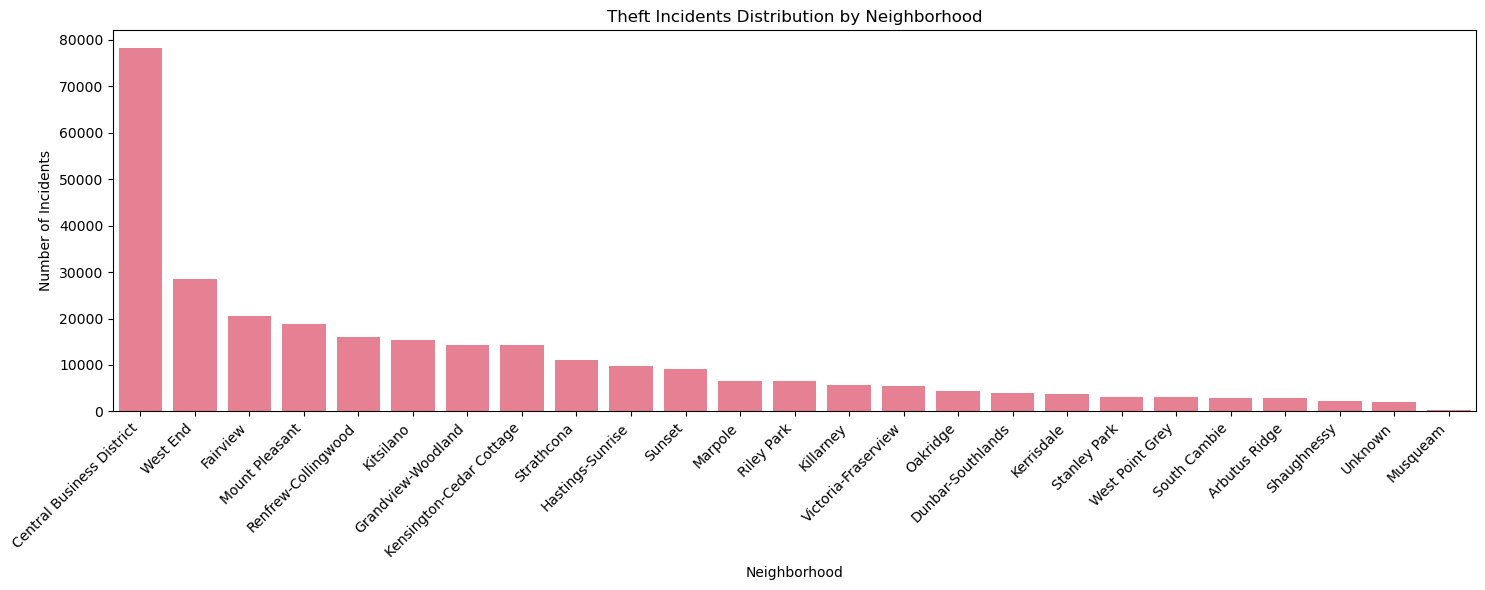

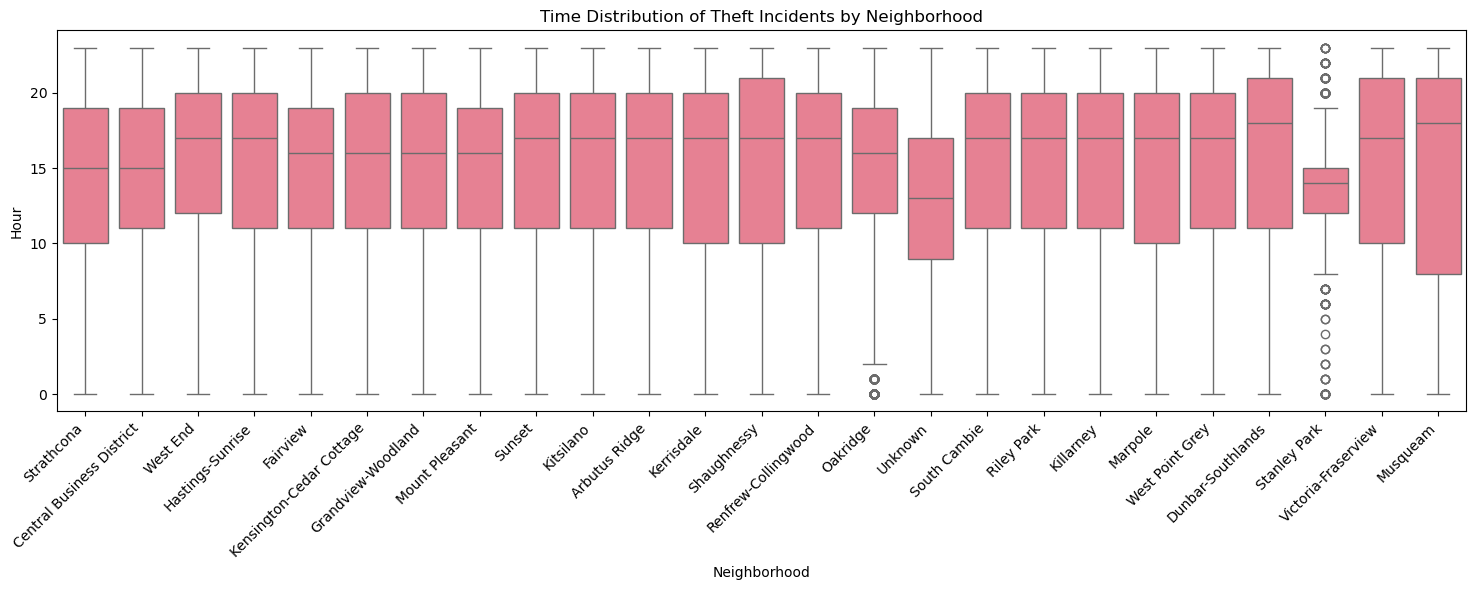

In [16]:
# Calculate neighborhood-level statistics
neighborhood_stats = theft_df.groupby('NEIGHBOURHOOD').agg({
    'TYPE': 'count',                   # Total incidents
    'HOUR': ['mean', 'std'],           # Average time and std
    'IsWeekend': 'mean',               # Weekend incident ratio
    'DistanceFromCenter': 'mean'       # Average distance from center
}).round(3)

# Rename columns
neighborhood_stats.columns = ['Total Incidents', 'Average Time', 'Time Std', 'Weekend Incident Ratio', 'Average Distance from Center']

# Display neighborhood statistics
print(" Neighborhood Crime Statistics:")
display(neighborhood_stats.head())

# Visualize neighborhood incident distribution
plt.figure(figsize=(15, 6))
sns.barplot(x=neighborhood_stats.index, 
           y=neighborhood_stats['Total Incidents'],
           order=neighborhood_stats.sort_values('Total Incidents', ascending=False).index)
plt.title('Theft Incidents Distribution by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Analyze neighborhood time patterns
plt.figure(figsize=(15, 6))
sns.boxplot(x='NEIGHBOURHOOD', y='HOUR', data=theft_df)
plt.title('Time Distribution of Theft Incidents by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Hour')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Spatiotemporal Analysis

### 3.1 Theft Distribution by Neighborhood

Analyze the distribution of theft incidents across different neighborhoods.

In [17]:
import os

# Create geographical heatmap with adjusted parameters
vancouver_center = [theft_df['Latitude'].mean(), theft_df['Longitude'].mean()]
m = folium.Map(location=vancouver_center, zoom_start=13)

# Add heatmap layer with refined parameters
heat_data = [[row['Latitude'], row['Longitude']] for index, row in theft_df.iterrows()]
HeatMap(
    heat_data,
    radius=8,          # 减小热点半径
    blur=5,            # 减小模糊程度
    max_zoom=15,       # 增加最大缩放级别
    min_opacity=0.3,   # 降低最小不透明度
    gradient={         # 自定义渐变色
        0.2: '#fee0d2',
        0.4: '#fc9272',
        0.6: '#de2d26',
        0.8: '#a50f15'
    }
).add_to(m)

# Add neighborhood boundaries for better context
geo_json = 'vancouver_neighborhoods.geojson'  # 如果有边界数据的话
if os.path.exists(geo_json):
    folium.GeoJson(
        geo_json,
        style_function=lambda x: {
            'fillColor': 'transparent',
            'color': 'black',
            'weight': 1
        }
    ).add_to(m)

# Add a legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 150px; height: 90px; 
     border:2px solid grey; z-index:9999; background-color:white;
     opacity:0.8;
     font-size:12px;
     padding: 10px">
     <p><strong>Crime Density</strong></p>
     <p style="color:#fee0d2">&#9632; Low</p>
     <p style="color:#de2d26">&#9632; Medium</p>
     <p style="color:#a50f15">&#9632; High</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add scale bar
folium.plugins.MeasureControl().add_to(m)

# Display map
m

### 3.2 Peak Time Analysis

Analyze temporal patterns of theft incidents to identify peak times.

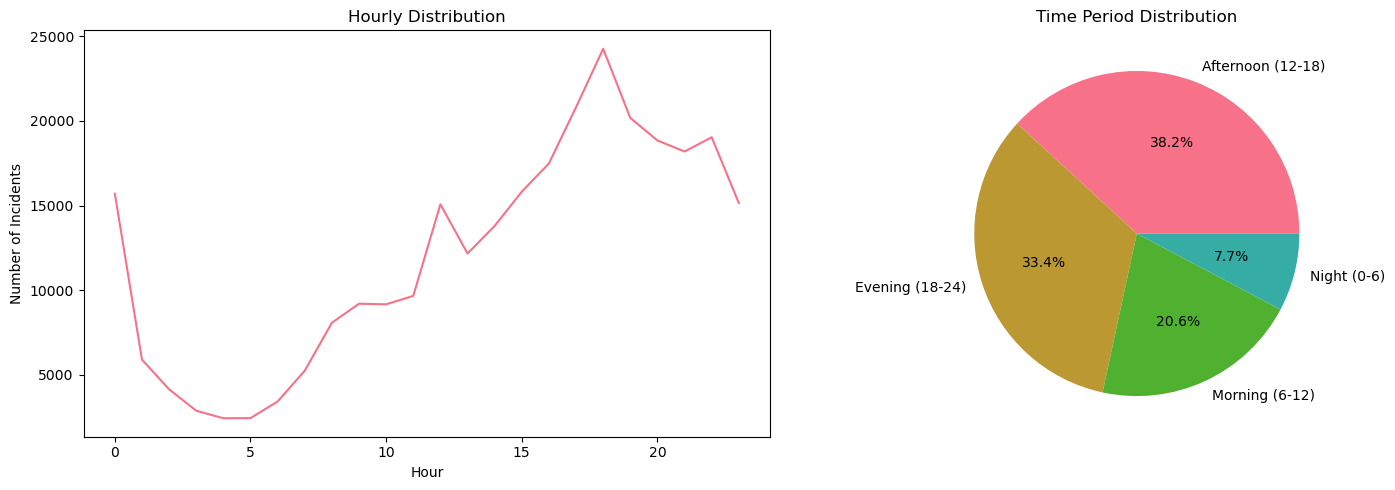

In [9]:
# Analyze time distribution
plt.figure(figsize=(15, 5))

# Hourly distribution
plt.subplot(1, 2, 1)
hourly_counts = theft_df['HOUR'].value_counts().sort_index()
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Hourly Distribution')
plt.xlabel('Hour')
plt.ylabel('Number of Incidents')

# Time period distribution
plt.subplot(1, 2, 2)
time_period_counts = theft_df['TimeOfDay'].value_counts()
plt.pie(time_period_counts, labels=time_period_counts.index, autopct='%1.1f%%')
plt.title('Time Period Distribution')

plt.tight_layout()
plt.show()